In [1]:
import ROOT
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/06


Define a useful function that flattens out a column for plotting

In [2]:
# Convert contents of column into a flat list that can be plotted with matplotlib
# Second arg is for case where container is a vector-of-vectors (e.g. track cov matrix)
# in which case the i-th element is taken. Not used for vector
def AsList(column,element):
    outputList = []
    for event in column:
        if hasattr(event, '__len__'):
            for item in event:
                if hasattr(item, '__len__'):
                    outputList.append(item[element])
                else:
                    outputList.append(item)
        else:
            outputList.append(event)
    return outputList

In [3]:
# Create dataframe from PHYSLITE

data_folder = '../datafiles/mc20_13TeV.600031.PhPy8EG_A14_ttbar_hdamp258p75_MECoff_grec_allhad.deriv.DAOD_PHYSLITE.e8041_s3681_r13145_p5267/'
df = ROOT.RDataFrame("CollectionTree", data_folder + 'DAOD_PHYSLITE.30180500._000435.pool.root.1')

### Exploring the dataframe

Not all branches of PHYSLITE can be read directly by ROOT.

The readable branches all have 'AuxDyn' in their name. Additionally they must be data type that does not require ATLAS libraries to read.

A list of readable data types is below.

In [4]:
# Only try to look at quantities that can be directly inspected with ROOT (e.g. no ATLAS libraries needed)

allowedTypes = [
    'ROOT::VecOps::RVec<vector<int>>',
    'ROOT::VecOps::RVec<float>',
    'ROOT::VecOps::RVec<UInt_t>',
    'ROOT::VecOps::RVec<int>',
    'ROOT::VecOps::RVec<vector<float>>',
    'ROOT::VecOps::RVec<char>',
    'ROOT::VecOps::RVec<unsigned short>',
    'ROOT::VecOps::RVec<unsigned int>',
    'ROOT::VecOps::RVec<unsigned char>',
    'ROOT::VecOps::RVec<double>',
    'ROOT::VecOps::RVec<set<unsigned int>>',
    'Float_t',
    'Char_t',
    'UInt_t',
    'ULong64_t',
    'ROOT::VecOps::RVec<string>',
    'ROOT::VecOps::RVec<vector<string>>',
    'ROOT::VecOps::RVec<ULong64_t>',
    'ROOT::VecOps::RVec<short>',
    'ROOT::VecOps::RVec<vector<vector<unsigned int> >>'
]

In [15]:
# Get list of readable branches
# The list auxDyn will contain all the name and data type of all readable branches
auxDyn = []
for name in df.GetColumnNames():
    if "AuxDyn" in str(name):
        datatype = df.GetColumnType(name)
        if datatype in allowedTypes: 
            auxDyn.append((str(name),datatype))

In [6]:
# Print out available collection names
collectionNames = []
for item in auxDyn:
    collectionName = item[0].split(".")[0].replace("AuxDyn","") 
    if (collectionName not in collectionNames):
        collectionNames.append(collectionName)
        print(collectionName)

AnalysisJets
AnalysisPhotons
AnalysisTauJets
AntiKt10TruthSoftDropBeta100Zcut10Jets
AntiKt4TruthDressedWZJets
BTagging_AntiKt4EMPFlow
CombinedMuonTrackParticles
EventInfo
ExtrapolatedMuonTrackParticles
GSFConversionVertices
GSFTrackParticles
HardScatterParticles
HardScatterVertices
InDetTrackParticles
Kt4EMPFlowEventShape
MET_Core_AnalysisMET
MET_Truth
MuonSpectrometerTrackParticles
PrimaryVertices
TauTracks
TruthBoson
TruthBosonsWithDecayParticles
TruthBosonsWithDecayVertices
TruthBottom
TruthElectrons
TruthEvents
TruthNeutrinos
TruthPhotons
TruthPrimaryVertices
TruthTop
egammaClusters
AnalysisMuons
TruthMuons
AnalysisElectrons
TruthTaus
TruthForwardProtons


In [7]:
# List available branches and types, user having selected a collection
collectionName = 'AnalysisMuons'
for item in auxDyn:
    if (collectionName+'AuxDyn' in item[0]): print(item[0],'-->',item[1])

AnalysisMuonsAuxDyn.pt --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.eta --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.phi --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.ptcone20 --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.ptvarcone20 --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.ptcone30 --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.ptvarcone30 --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.topoetcone20 --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.charge --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.MuonSpectrometerPt --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.InnerDetectorPt --> ROOT::VecOps::RVec<float>
AnalysisMuonsAuxDyn.truthType --> ROOT::VecOps::RVec<int>
AnalysisMuonsAuxDyn.truthOrigin --> ROOT::VecOps::RVec<int>
AnalysisMuonsAuxDyn.truthParticleLink.m_persKey --> ROOT::VecOps::RVec<UInt_t>
AnalysisMuonsAuxDyn.truthParticleLink.m_persIndex --> ROOT::VecOps::RVec<UInt_t>
AnalysisMuonsAuxDyn.EnergyLoss --> ROOT::VecOps::RVec<float>
Ana

## Some useful RDataFrame operations

### Count
Returns number of events. The return value can be printed by using the GetValue method

In [8]:
#Print total number of events
events = df.Count()
events.GetValue()

40000

### Filter
Filter rows based on some condition, that is, apply a cut. Filters are defined as strings of C++ code. The variables used must correspond to the name of a branch in the RDataFrame.
Filters can be given a name, which enables use of e.g. the Report method.

df_filtered = df.Filter('some C++ code that defines cut', name (voluntary))

Some examples:

In [9]:
# Require exactly one electron
df_oneElectron = df.Filter('AnalysisElectronsAuxDyn.pt.size() == 1', 'Exactly one electron')
# Require one muon with pt > 60 GeV
df_highPtMuon = df.Filter('AnalysisMuonsAuxDyn.pt.size() > 0 && AnalysisMuonsAuxDyn.pt[0] > 60000', 'Muon with pt > 60 GeV')
# Get number of events after pt cut
df_highPtMuon.Count().GetValue()

64

### Report
The Report method returns a cutflow for a dataframe. The cutflow can be printed using the Print method

In [10]:
oneElectron_cutflow = df_oneElectron.Report()
oneElectron_cutflow.Print()

Exactly one electron: pass=4202       all=40000      -- eff=10.51 % cumulative eff=10.51 %


## Plotting with matplotlib
Several of the columns in the RDataFrame are vectors, and we need to flatten them into a list before they can be plotted with matplotlib. The function AsList (in cell 4) flattens RDataFrame columns.

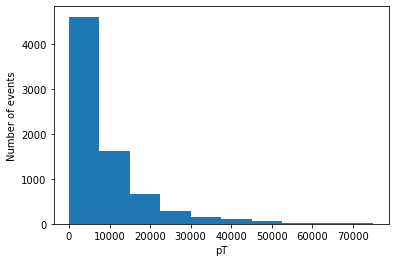

In [11]:
# Plotting with matplotlib

# Column to plot
col = 'AnalysisMuonsAuxDyn.pt'
# Convert to numpy
col_np = df.AsNumpy(columns=[col])[col]
# Convert to flat list
col_list = AsList(col_np, 0)

# Make histogram
plt.hist(col_list, range=(0,75000));
plt.xlabel('pT');
plt.ylabel('Number of events');


## Apply full set of cuts and plot muon pt for resulting events

In [12]:
# Cuts: two muons total, pt of both muons > 10 GeV

df = df.Filter('AnalysisMuonsAuxDyn.pt.size() == 2', 'Exactly two muons')
df = df.Filter('AnalysisMuonsAuxDyn.pt[0] > 10000 && AnalysisMuonsAuxDyn.pt[1] > 10000', 'Muons have pt > 10 GeV')

In [13]:
# Get cutflow
report = df.Report()
report.Print()

Exactly two muons: pass=630        all=40000      -- eff=1.58 % cumulative eff=1.58 %
Muons have pt > 10 GeV: pass=45         all=630        -- eff=7.14 % cumulative eff=0.11 %


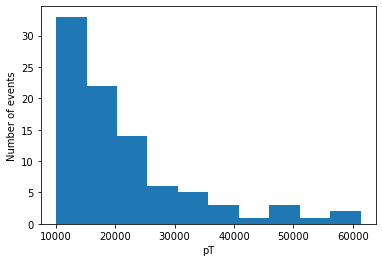

In [14]:
# Make plot of pt
pt_list = AsList(df.AsNumpy(columns=['AnalysisMuonsAuxDyn.pt'])['AnalysisMuonsAuxDyn.pt'], 0)
plt.hist(pt_list);
plt.xlabel('pT');
plt.ylabel('Number of events');